Pytorch Datasets and Dataloaders <br>
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html <br>
    https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

Installing Pytorch and preparing the environment: <br>
From tool on Pytorch's installation website (https://pytorch.org/get-started/locally/) <br>
Use the command: conda install pytorch torchvision torchaudio pytorch-cuda=11.6 -c pytorch -c nvidia <br>
Will also need to install pandas, matplotlib, scikit-learn (sklearn), and seaborn with conda

The subcellular localization data is the neighborhood annotations for MCF7 cells from Orre et al.

In [1]:
# Import packages
import re
from pathlib import Path
import numpy as np
import pandas as pd
import os
from pdb import set_trace
import matplotlib.pyplot as plt
import PIL #for images
import copy

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import models
from torch import nn
from torchvision.transforms import Resize
import torchvision.transforms as T

In [2]:
#Specifications

# Data splitting
ImagePathString = 'images_patient_0905'
ValFrac = 0.2

# Training and Validation Data Sets
ImageTransformationName = 'None'
if ImageTransformationName == 'GaussianBlur':
    blur_sigma = (1.1,1.1)
    # (0.9,0.9) is a decent value
    
# Model
ModelWeightSpefication = 'random'
if ModelWeightSpefication == 'random':
    ModelWeights = None
if ModelWeightSpefication == 'pretrained':
    ModelWeights = models.ResNet50_Weights.DEFAULT
    # models.ResNet50_Weights.DEFAULT is some pretrained set of values

# Optimizer
Weight_Decay = 0.0
#  penalizes for too many weights - helps prevent overfitting
Momentum = 0.95
#  a way to smooth noise that is passed to the optimizer, 0.9
#  momentum is deterimental without label smoothing
learner_rate = 1e-3
# 1e-3 seems to work well

# Loss Function
Label_Smoothing = 0.1
#  was 0.1
#  sets the target of the loss function to something greater than 0 and less than 1
#  helps prevent overfitting

AddLayerForWeights = False
# Makes the loss weights equal to the fraction of each category label
# Note, a layer is added to the model so the outputs of the model are equal to the number of categories
#     This seems like a bug becuase that should already be the case

# Run the model
epochs = 75

In [3]:
# Check to see if the GPU is available and store it as a variable so tensors can be moved to it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('Is cuda available?:', torch.cuda.is_available())
print('cuda version:', torch.version.cuda)
dev = "cuda:0"

Using device: cuda
Is cuda available?: True
cuda version: 11.7


In [4]:
# Set the file path containing the images to be classified
path2 = Path(ImagePathString)

In [5]:
# Define necessary classes and functions

# Create the CustomImageDataset class from the parent Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, annotations_DF, img_dir, transform=None, target_transform=None,ImageExtension='.png'):
        self.img_labels = annotations_DF
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.ImageExtension = ImageExtension

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + self.ImageExtension)
        image = read_image(img_path)
        #image = PIL.Image.open(img_path)
        #    attempt to get around byte vs. float problem: https://pytorch.org/hub/pytorch_vision_resnet/
        #image = image.double()
        #image = plt.imread(img_path)
        #  used in troubleshooting torchvision vs matplatlib formats
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Create a function to output training and validation annotation data frames from a single annotations file
def GetTrainValAnnotDataFrames(annotations_file,img_dir,val_frac):
    # Inputs:
    # annotations_file: a directory to an comma separated file with image filenames and their labels
    # img_dir: a directory to the folder containing the image files
    # val_frac: the fraction of samples used for validation
    
    # read the csv file with the sample annotations
    annotationsDF = pd.read_csv(annotations_file,header=None,sep='\t',dtype=str)
    
    # read the directory containing the images to get a list of filenames
    #     strip the file extension so the filenames match the annotations in annotationsDF
    FileList = os.listdir(img_dir)
    Files_Without_Extension = [os.path.splitext(file)[0] for file in FileList]
    
    # remove entries in the annotationsDF that are not in the list of images
    #     this is done so that the training and validation sets are divided correctly
    OverlappingIndices = [item in Files_Without_Extension for item in annotationsDF.iloc[:,0]]
    annotationsDF = annotationsDF.loc[OverlappingIndices,:]
    
    unique_labels = np.unique(annotationsDF.iloc[:,1])
    ValidationDF = pd.DataFrame()
    TrainingDF = pd.DataFrame()
    for label in unique_labels:
        Subset_DF = annotationsDF.loc[annotationsDF.iloc[:,1]==label,:]
        n_validation = int(np.floor(val_frac * len(Subset_DF.iloc[:,0])))
        Validation_Subset = Subset_DF.sample(n=n_validation,ignore_index=True,random_state=42)
        ValidationDF = pd.concat(objs=[ValidationDF,Validation_Subset],axis=0)
        
    Training_rows = [gene not in ValidationDF.iloc[:,0].to_numpy() for gene in annotationsDF.iloc[:,0].to_numpy()]
    TrainingDF = annotationsDF.loc[Training_rows,:]
    
    return(ValidationDF, TrainingDF, unique_labels)

# Function to convert a torchvision tensor to the default format for matplotlib
    # matplotlib.pyplot.imshow interprets an RGB vector as shape (N,M,3) 
    # torchvision.io.read_image reads an RGB image as shape (3,N,M)
def ShowTorchvisionImage(ImageTensor):
    ImageTensor_t1 = ImageTensor.transpose(1,2)
    ImageTensor_t2 = ImageTensor_t1.transpose(0,2)
    plt.imshow(ImageTensor_t2)
    
def LabelArray_to_Tensor(input_array,labels_unique):
    # converts a label array of strings to a tensor of floats
    # Inputs:
    #   input_array: the array of strings that are labels
    #   labels_unique: an ordered list of the unique labels possible for the data set
    # Outputs:
    #   output_tensor: a tensor of floats, one unique float corresponding to each label
    
    int_label = np.arange(0,len(labels_unique))
    i = 0
    for label in labels_unique:
        indices = [label == item for item in input_array]
        input_array[indices] = int_label[i]
        i = i+1

    input_array = input_array.astype(float)
    output_tensor = torch.as_tensor(input_array)
    output_tensor = output_tensor.long()
  
    return(output_tensor)

# Function for training the weights of the model
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss

        
        # convert to float32 to avoid error stating byte expected but found float
        X = X.to(torch.float32)
        X = X.to(dev)
        pred = model(X)
        
        # convert the labels into a tensor of intigers and compute the loss
        y = np.asarray(y)
        y = LabelArray_to_Tensor(y,labels_unique)
        y = y.to(dev)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
             

    loss = loss.item()
    return(loss)
            
# Function for validating the weights of the model
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            
            # convert to float32 to avoid error stating byte expected but found float
            X = X.to(torch.float32)
            X = X.to(dev)
            pred = model(X)
            
            # convert the labels into a tensor of intigers and compute the loss
            y = np.asarray(y)
            y = LabelArray_to_Tensor(y,labels_unique)
            y = y.to(dev)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    return(test_loss,correct)

6173
6174
Label: Nuclear


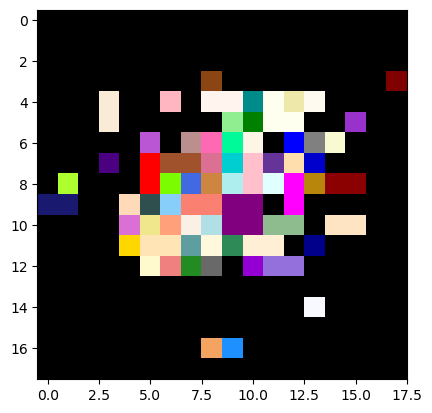

In [6]:
# Split the samples up into training and validation
Val_DF, Train_DF, unique_labels = GetTrainValAnnotDataFrames(annotations_file='SubCellBarcode.MCF7.0622.txt',img_dir=path2,val_frac=ValFrac)
labels_unique = np.unique(Train_DF.iloc[:,1])

TrainingData = CustomImageDataset(annotations_DF=Train_DF,img_dir=path2)
ValData = CustomImageDataset(annotations_DF=Val_DF,img_dir=path2)


# Create the data sets with transformations from the training and validation set data frames defined above
if ImageTransformationName == 'None':
    TrainingData = CustomImageDataset(annotations_DF=Train_DF,img_dir=path2)
    ValData = CustomImageDataset(annotations_DF=Val_DF,img_dir=path2)

if ImageTransformationName == 'SpecifiedReorder':
    TrainingData = CustomImageDataset(annotations_DF=Train_DF,img_dir=path2,transform=SpecifiedReorder(sample_reorder_array))
    ValData = CustomImageDataset(annotations_DF=Val_DF,img_dir=path2,transform=SpecifiedReorder(sample_reorder_array))
    
if ImageTransformationName == 'GaussianBlur':
    transform = T.GaussianBlur(kernel_size=(7, 13), sigma=blur_sigma)
    TrainingData = CustomImageDataset(annotations_DF=Train_DF,img_dir=path2,transform=transform)
    ValData = CustomImageDataset(annotations_DF=Val_DF,img_dir=path2,transform=transform)

    
# Other possible transformations
#TrainingData = CustomImageDataset(annotations_DF=Train_DF,img_dir=path2,transform=Resize([224,224]))
#TrainingData = CustomImageDataset(annotations_DF=Train_DF,img_dir=path2,transform=RandomPairReposition())

# Define Data Loaders
train_dataloader = DataLoader(TrainingData, batch_size=64, shuffle=True, drop_last=True)
val_dataloader = DataLoader(ValData, batch_size=64, shuffle=True, drop_last=True)


# Check to see if the number of training data points plus validation data points sum to total data points
print(len(Val_DF.index)+len(Train_DF.index))
n_files = len(os.listdir(path2))
print(n_files)

# Display a training image and its corresponding label.
train_features, train_labels = next(iter(train_dataloader))
#print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
ShowTorchvisionImage(img)
print(f"Label: {label}")

In [7]:
# Define the model

# initial model weights
model = models.resnet50(weights=ModelWeights)
#model = models.resnet50() #without initial weights defined - good for patients not re-arranged

# Add a final layer to the model where the output is equal to the number of classes (labels)
#     This is required to use loss weights
if AddLayerForWeights:
    model.fc = nn.Sequential(
        model.fc,
        nn.Linear(1000, 4)
    )

model = model.to(dev)

# see the model architecture if desired
#model.parameters

In [8]:
# Define the loss function

loss_fn = nn.CrossEntropyLoss()

if AddLayerForWeights:
    # Weights for each class for loss function
    n_cytosol = float(sum(TrainingData.img_labels.iloc[:,1]=='Cytosol'))
    n_mitochondria = float(sum(TrainingData.img_labels.iloc[:,1]=='Mitochondria'))
    n_nuclear = float(sum(TrainingData.img_labels.iloc[:,1]=='Nuclear'))
    n_secretory = float(sum(TrainingData.img_labels.iloc[:,1]=='Secretory'))
    n_total = len(TrainingData.img_labels.iloc[:,1])
    LossWeights = (torch.tensor([n_cytosol,n_mitochondria,n_nuclear,n_secretory])/n_total)**-1
    LossWeights = LossWeights.to(device)
    loss_fn = nn.CrossEntropyLoss(label_smoothing=Label_Smoothing,weight=LossWeights)

In [9]:
# Define the optimizer

optimizer = torch.optim.SGD(model.parameters(), lr=learner_rate, weight_decay=Weight_Decay, momentum=Momentum)
#optimizer = torch.optim.SGD(model.parameters(), lr=learner_rate)

In [10]:
# Run the model
from sklearn.metrics import precision_score

PerformanceDF = pd.DataFrame(index=range(epochs),columns=['Epoch','TrainLoss','ValLoss','TrainAcc','ValAcc', 'cyto_prec','mito_prec','nucl_prec','secr_prec'])
print(f"{'Epoch':>5s}{'Train Loss':>13s}{'Val Loss':>11s}{'Train Accuracy':>17s}{'Val Accuracy':>15s}{'Cyto Precision':>15s}{'Mito Precision':>15s}{'Nuclear Precision':>15s}{'Secretory Precision':>15s}\n")

for t in range(epochs):        
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    val_loss,val_accuracy = test_loop(val_dataloader, model, loss_fn)
    train_loss2,train_accuracy = test_loop(train_dataloader, model, loss_fn)
    
    # precision 
    y_pred = []
    y_true = []

    # iterate over test data
    for X, y in val_dataloader:
    
        X = X.to(torch.float32)
        X = X.to(dev)
        output = model(X) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        output_string = [unique_labels[i] for i in output]
        
        y_pred.extend(output_string) # Save Prediction
        
        labels = y
        y_true.extend(labels) # Save Truth
        
    test_precision = precision_score(y_true, y_pred, average=None)
    
    Epoch = t
    print(f"{str(Epoch):>5s}{train_loss:>13f}{val_loss:>11f}{train_accuracy*100:>16f}%{val_accuracy*100:>14f}%{test_precision[0]*100:>16f}%{test_precision[1]*100:>16f}%{test_precision[2]*100:>16f}%{test_precision[3]*100:>16f}%")
    PerformanceDF.loc[t,:]=[Epoch,train_loss,val_loss,train_accuracy*100,val_accuracy*100,test_precision[0]*100,test_precision[1]*100,test_precision[2]*100,test_precision[3]*100]
    
    # note: I am not sure how to load the MSD into the model
    if Epoch == 0:
        highest_val_accuracy = 0 
        MSD0 = copy.deepcopy(model.state_dict())
    if val_accuracy > highest_val_accuracy:
        highest_val_accuracy = val_accuracy
        MSD_Best = copy.deepcopy(model.state_dict())
    
print("Done!")

Epoch   Train Loss   Val Loss   Train Accuracy   Val Accuracy Cyto Precision Mito PrecisionNuclear PrecisionSecretory Precision

    0     1.443864   1.452468       41.266950%     38.717532%       48.235294%        0.000000%       28.822055%       18.320611%
    1     1.440329   1.799837       28.799838%     28.084416%       55.102041%       12.500000%       31.782946%       19.010417%


/home/ec2-user/miniconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    2     1.439086   1.454076       46.286177%     44.886364%       48.253069%        0.000000%       34.615385%        0.000000%
    3     1.348795   1.398165       43.371787%     41.558442%       53.900709%        0.000000%       32.845528%       17.647059%
    4     1.427290   1.398140       33.151184%     31.006494%       61.003861%        0.000000%       31.336406%       20.921305%
    5     1.785564   1.360356       44.586116%     41.071429%       49.469496%        0.000000%       36.395760%       18.181818%
    6     1.593145   1.427849       45.537341%     45.535714%       51.219512%       12.962963%       40.175953%        0.000000%
    7     1.639095   1.558433       35.559603%     32.386364%       60.474308%       16.071429%       35.245902%       22.550832%
    8     1.373208   1.367196       44.869460%     42.126623%       55.000000%       25.000000%       31.761006%       41.666667%


/home/ec2-user/miniconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    9     1.330813   1.514523       43.209877%     39.285714%       58.090186%        0.000000%       35.384615%       25.984252%
   10     1.170686   1.393203       46.144505%     39.935065%       55.069930%       16.666667%       38.144330%       24.495677%


/home/ec2-user/miniconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


   11     1.236460   1.384622       50.192269%     43.587662%       50.503919%        0.000000%       40.390879%        6.250000%
   12     1.285566   1.315040       53.228091%     44.480519%       50.653595%       23.076923%       40.310078%       24.475524%
   13     1.343446   1.474457       47.965999%     39.285714%       54.901961%       14.084507%       32.534930%       28.108108%
   14     1.565989   1.395739       52.216151%     41.314935%       57.377049%        0.000000%       32.598425%       31.521739%
   15     1.383949   1.438104       56.891318%     40.340909%       52.654867%       11.627907%       40.559441%       26.691729%
   16     1.215569   1.479556       60.028334%     39.935065%       53.455285%       15.000000%       34.541578%       25.531915%
   17     1.095212   1.478227       63.893949%     44.074675%       53.214774%       19.512195%       39.887640%       30.681818%
   18     0.723471   1.659617       64.035620%     44.886364%       50.837989%       30.43

In [11]:
print('Best recorded epoch validation accuracy: ' + str(round(100*highest_val_accuracy,2)))

BestModel = copy.deepcopy(model)
BestModel.load_state_dict(MSD_Best)
val_loss,best_val_accuracy = test_loop(val_dataloader, BestModel, loss_fn)
print('Best epoch recalculated validation accuracy: ' + str(round(100*best_val_accuracy,2)))

FirstModel = copy.deepcopy(model)
FirstModel.load_state_dict(MSD0)
val_loss,first_val_accuracy = test_loop(val_dataloader, FirstModel, loss_fn)
print('First epoch validation Accuracy: ' + str(round(100*first_val_accuracy,2)))

Best recorded epoch validation accuracy: 46.35
Best epoch recalculated validation accuracy: 45.13
First epoch validation Accuracy: 38.96


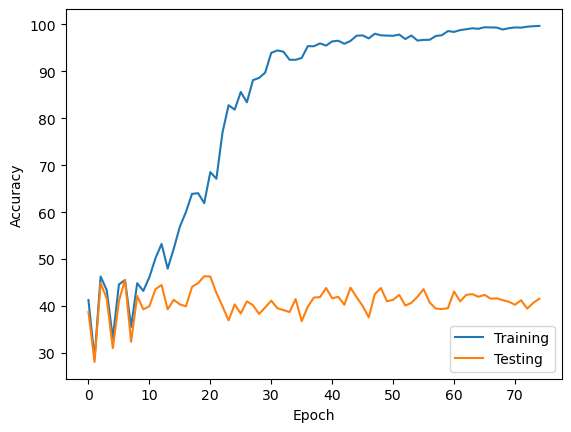

In [12]:
# Graph accuracy for training and validation

import matplotlib.pyplot as plt
plt.plot(PerformanceDF['Epoch'], PerformanceDF['TrainAcc'])
plt.plot(PerformanceDF['Epoch'], PerformanceDF['ValAcc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Testing'], loc='lower right')
plt.savefig('accuracy_0907.pdf')
plt.show()

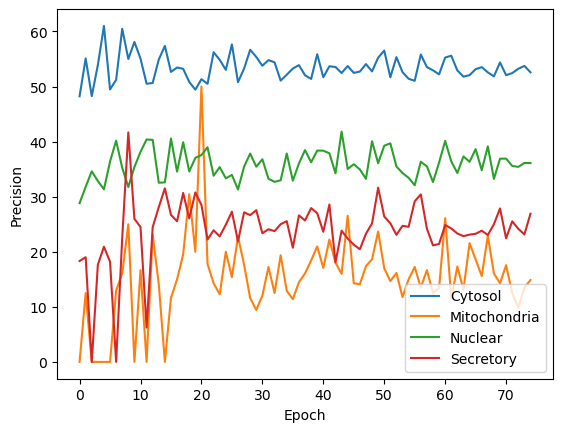

In [13]:
# Graph accuracy for precision of each compartment

import matplotlib.pyplot as plt
plt.plot(PerformanceDF['Epoch'], PerformanceDF['cyto_prec'])
plt.plot(PerformanceDF['Epoch'], PerformanceDF['mito_prec'])
plt.plot(PerformanceDF['Epoch'], PerformanceDF['nucl_prec'])
plt.plot(PerformanceDF['Epoch'], PerformanceDF['secr_prec'])
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Cytosol', 'Mitochondria','Nuclear','Secretory'], loc='lower right')
plt.savefig('precision_0907.pdf')
plt.show()

[Text(0.5, 25.722222222222214, '\n\nPrediction'),
 Text(45.72222222222221, 0.5, 'Label\n\n')]

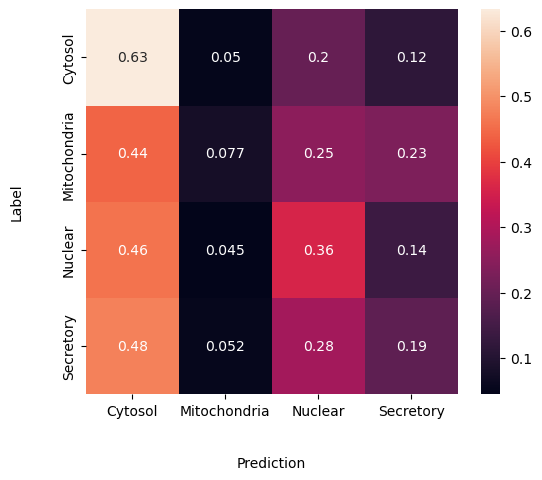

In [14]:
# build confusion matrix
#   https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

from sklearn.metrics import confusion_matrix
import seaborn as sn

y_pred = []
y_true = []

# iterate over test data
for X, y in val_dataloader:
    
        X = X.to(torch.float32)
        X = X.to(dev)
        output = model(X) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        output_string = [unique_labels[i] for i in output]
        
        y_pred.extend(output_string) # Save Prediction
        
        labels = y
        y_true.extend(labels) # Save Truth

# constant for classes
classes = unique_labels

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix_norm = np.zeros((len(classes),len(classes)))
for i in np.arange(0,len(classes)):
    cf_matrix_norm[i,:] = cf_matrix[i,:]/sum(cf_matrix[i,:])

df_cm = pd.DataFrame(cf_matrix_norm, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (6,5))
hm = sn.heatmap(df_cm, annot=True)
hm.set(xlabel='\n\nPrediction', ylabel='Label\n\n')


# plt.savefig('output.png')

In [15]:
# Validate Orientation of Confusion Matrix
#     Data labels go down the rows and predictions label the columns

# Print Confusion Matrix Row Sums
ConfusionMatrix_RowSums = [sum(cf_matrix[i,:]) for i in np.arange(0,len(unique_labels))]
print(ConfusionMatrix_RowSums)

# Print Quantity of Items with each label
ValDF_UniqueLabelSums = [sum(Val_DF.iloc[:,1]==classes[i]) for i in np.arange(0,len(unique_labels))]
print(ValDF_UniqueLabelSums)

[555, 91, 337, 233]
[560, 92, 340, 240]


In [15]:
# ShowTorchvisionImage(RandomPairRepositionFunc(img))

Got 40% accuracy with significant higher than null true positive rates for every category with weight decay = 0, momentum=0 and label weighting. 1e-3 learning rate until ~90% accurate on training data, then 1e-4 learning rate.

Got a lower accuracy, but improved true positive rates for the other categories (not cytosol) when weight decay and momentum were added. Adding blur improved true positive rates and true negative rates, and slightly improved overall accuracy much (something to do with most genes being cytsolic and nuclear?). Blur sigma of (0.9,0.9) worked the best so far, but may continue to improve if I raise it more.

Get hightest validation accuracy there are not transformations, when patients have not been re-ordered, there is no label smoothing or momentum, no layer is added to the model, and there are no weights on the loss function, and no default weights are passed to the model. (72-73%)

Adding loss function weights works well too, brings accuracy to 70%.